First Steps: gradCAM
- works for any model
- discriminates classes (change y_c index)

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow.keras as keras
from tensorflow.keras.models import Model 
import wandb
import cv2 as cv
input_path = "C:/DL_Lab/IDRID_dataset/images/train/IDRiD_006.jpg"
#input_path = "C:/DL_Lab/IDRID_dataset_orig/images/train/IDRiD_001.jpg"

(1, 224, 224, 3)

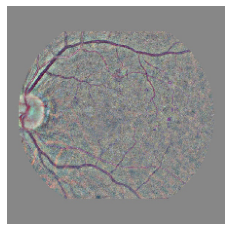

In [2]:
# load and import image with keras in RGB format
orig_image = load_img(input_path, target_size=(224,224))
image = img_to_array(orig_image) # scales to 0-255
#image = preprocess_input(image) # only for resnet/vgg models
image = np.expand_dims(image, axis=0)
plt.imshow(orig_image)
plt.axis("off")
image.shape

In [30]:
# pretrained model
# model = ResNet50(input_shape=(224,224,3), include_top=True, weights="imagenet")

# our pretrained model
model = wandb.restore('model.h5', run_path="stuttgartteam8/diabetic_retinopathy/24pjr9oi")
model = tf.keras.models.load_model('model.h5')


In [62]:
# cut_model = keras.Sequential()
# for i, l in enumerate(model.layers):
#         if i > 3: 
#             print(l.name, l.output_shape)
#             cut_model.add(l)
# cut_model.summary()

cut_model = keras.Sequential()
for i, l in enumerate(model.layers):
    if i==0:
        print(l.name, l.output_shape)
        cut_model.add(l)
    elif i > 3:
        print(l.name, l.output_shape)
        cut_model.add(l)
cut_model.summary()

input_2 [(None, 224, 224, 3)]
vgg16 (None, 7, 7, 512)
global_average_pooling2d (None, 512)
dense (None, 256)
dropout (None, 256)
dense_1 (None, 64)
dropout_1 (None, 64)
dense_2 (None, 32)
dropout_2 (None, 32)
dense_3 (None, 5)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
________________________

In [64]:
# find last conv layer name and get model that ends with it
for layer in reversed(cut_model.layers):
    # 'conv5_block3_out' with shape (None, 7, 7, 2048)
    if len(layer.output_shape) == 4:
        last_conv_layer = cut_model.get_layer(layer.name)
        break
# returns conv fmaps and model prediction when called
#gradModel = Model(inputs=cut_model.layers[0].get_output_at(0), outputs=[cut_model.layers[-9].output, cut_model.output])
gradModel = Model(inputs=cut_model.input, outputs=[cut_model.layers[0].output, cut_model.output])
#gradModel = Model(inputs=cut_model.input, outputs=[last_conv_layer.output, cut_model.output])

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "block1_conv1". The following previous layers were accessed without issue: []

In [18]:
with tf.GradientTape() as tape:
    # get predictions from conv model and model
    (fmaps, preds) = gradModel(image)

    # get logit of winner-class
    y_c = preds[:,np.argmax(preds[:,])]

grads = tape.gradient(y_c, fmaps)[0]
grads.shape

TensorShape([64])

In [10]:
# apply global max pooling = collapse axes 0 and 1
weights = tf.reduce_mean(grads, axis=(0,1))
# calculate the class activation map
cam = tf.reduce_mean(fmaps[0] * weights, axis=2)
# apply relu 
cam = tf.nn.relu(cam)
plt.imshow(cam, cmap="viridis", alpha=0.8)

InvalidArgumentError: Invalid reduction dimension (1 for input with 1 dimension(s) [Op:Mean]

In [ ]:
# upsample cam to original image size 224x224
ups_cam = cv.resize(cam.numpy(), (224, 224))
# normalize to range [0,1]
min = tf.math.reduce_min(ups_cam)
max = tf.math.reduce_max(ups_cam)
ups_cam = ((ups_cam - min) / (max - min))
plt.imshow(ups_cam, cmap="viridis", alpha=0.8)

In [ ]:
"overlay with open cv"
# change from 2d to 3d to match image shape
cam3d = np.expand_dims(ups_cam, axis=2)
cam3d = np.tile(cam3d, [1,1,3])
# opencv requires uint8 and [0,255]
cam3d = np.uint8(cam3d*255)
orig_image = np.uint8(orig_image)
# create colormap and convert to RGB
cam3d_hm = cv.applyColorMap(cam3d, cv.COLORMAP_VIRIDIS)
cam3d_hm = cv.cvtColor(cam3d_hm, cv.COLOR_BGR2RGB)
# overlay both images
overlay = cv.addWeighted(orig_image, 0.3, cam3d_hm, 0.7, 0)
plt.imshow(overlay)
plt.axis("off")

In [ ]:
"overlay with open imshow"
plt.imshow(orig_image, alpha=1)
plt.imshow(ups_cam, cmap="viridis", alpha=0.7)
plt.axis("off")

Guided GradCAM